In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# columns of interest
cols_to_extract = ['eventid','imonth', 'iyear','iday',
 'country_txt','region_txt','provstate','city','latitude','longitude',
 'crit1','crit2','crit3',
 'attacktype1_txt',
 'success','suicide',
 'weaptype1_txt',
 'targtype1_txt',
 'gname',
 'individual','nperps','nperpcap',
 'claimed',
 'nkill','nkillter','nwound','nwoundte',
 'property','propextent_txt',
 'ishostkid','nhostkid','nhours','ndays','kidhijcountry',
 'ransom','ransomamt','ransompaid','hostkidoutcome_txt','nreleased']

# Load data
df = pd.read_excel('GTD_0617dist/globalterrorismdb_0617dist.xlsx',
                   index_col=0,usecols=cols_to_extract,
                   na_values = ['Unknown','-99','-9','Not Applicable'])

# replace some values not correctly dealt with by pandas import
df.replace(-9,np.nan,inplace=True)
df.replace(-99,np.nan,inplace=True)

# create a date column, then get rid of the seaparte year, month and day columns
# entries without month or day - treat as 1st January
df['imonth'].replace(0,1,inplace=True)
df['iday'].replace(0,1,inplace=True)
df['iyear']=pd.to_datetime(dict(year=df.iyear, month=df.imonth, day=df.iday)) 
df.rename(columns={'iyear':'date'}, inplace=True)
df.drop(['imonth','iday'],axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170350 entries, 197000000001 to 201701270001
Data columns (total 38 columns):
date                  170350 non-null datetime64[ns]
imonth                170350 non-null int64
iday                  170350 non-null int64
country_txt           170350 non-null object
region_txt            170350 non-null object
provstate             152649 non-null object
city                  160742 non-null object
latitude              165743 non-null float64
longitude             165744 non-null float64
crit1                 170350 non-null int64
crit2                 170350 non-null int64
crit3                 170350 non-null int64
success               170350 non-null int64
suicide               170350 non-null int64
attacktype1_txt       163925 non-null object
targtype1_txt         165477 non-null object
gname                 92044 non-null object
individual            170350 non-null int64
nperps                26173 non-null float64
nperpcap        

In [2]:
# look at the most common values in each column
print('TOP 2 VALUES IN EACH COLUMN:')
print('===================================')
for column in df.columns:
    top2 = df[column].value_counts().index[:2]
    print('{}: {}, {}'.format(column,top2[0],top2[1]))

TOP 2 VALUES IN EACH COLUMN:
date: 2016-09-21 00:00:00, 2016-12-01 00:00:00
imonth: 5, 7
iday: 1, 15
country_txt: Iraq, Pakistan
region_txt: Middle East & North Africa, South Asia
provstate: Baghdad, Northern Ireland
city: Baghdad, Karachi
latitude: 33.3, -12.046378
longitude: -77.042791, 44.4
crit1: 1, 0
crit2: 1, 0
crit3: 1, 0
success: 1, 0
suicide: 0, 1
attacktype1_txt: Bombing/Explosion, Armed Assault
targtype1_txt: Private Citizens & Property, Military
gname: Taliban, Shining Path (SL)
individual: 0, 1
nperps: 1.0, 2.0
nperpcap: 0.0, 1.0
claimed: 0.0, 1.0
weaptype1_txt: Explosives/Bombs/Dynamite, Firearms
nkill: 0.0, 1.0
nkillter: 0.0, 1.0
nwound: 0.0, 1.0
nwoundte: 0.0, 1.0
property: 1.0, 0.0
propextent_txt: Minor (likely < $1 million), Major (likely > $1 million but < $1 billion)
ishostkid: 0.0, 1.0
nhostkid: 1.0, 2.0
nhours: 0.0, 1.0
ndays: 1.0, 2.0
kidhijcountry: Colombia, Guatemala
ransom: 0.0, 1.0
ransomamt: 0.0, 1000000.0
ransompaid: 0.0, 1000000.0
hostkidoutcome_txt: Hosta

In [3]:
# Some rows are identical to each other.
# E.g. 100 duplicates of GTD ID 201609210029. In this case seems to be
# 100 separte incidents of an explosive being detonated in a civilian
# house. So I will treat the duplicates as genuine.
dups = df.duplicated(keep=False)
print('There are',dups.sum(),'rows which have duplicated information in other rows.')

There are 16218 rows which have duplicated information in other rows.


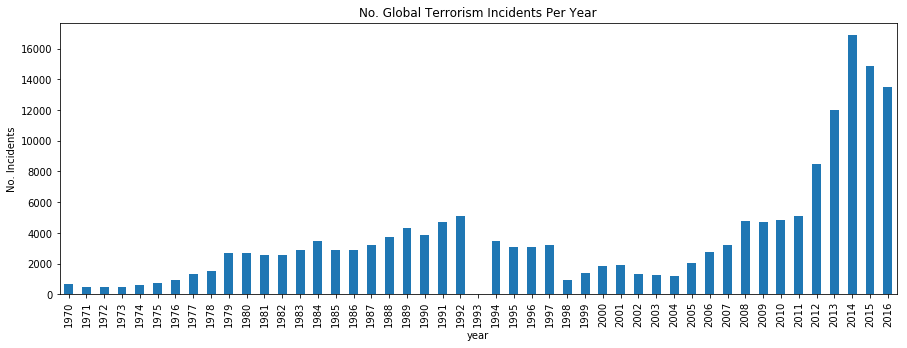

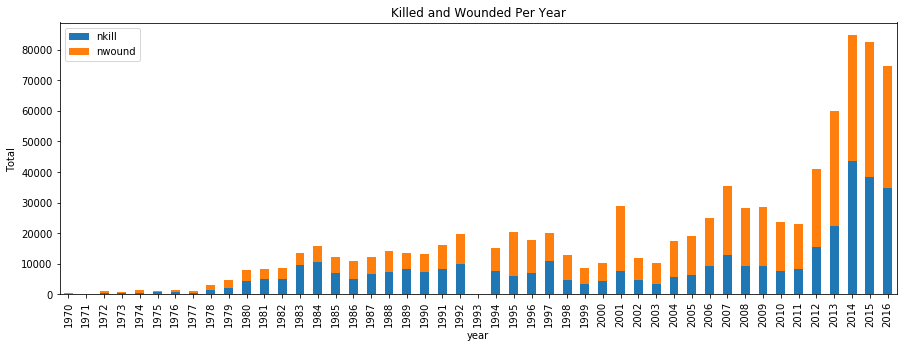

In [4]:
# Plot some basic stats

# total incidents per year
tot_inc_yr = df.resample('A',on='date')['date'].count()
tot_inc_yr.index = tot_inc_yr.index.year
tot_inc_yr.name = 'n_incidents'
tot_inc_yr.index.name = 'year'
plt.figure(figsize=(15,5))
tot_inc_yr.plot.bar(title='No. Global Terrorism Incidents Per Year')
plt.ylabel('No. Incidents');

# total deaths and wounded per year
tot_kill_yr = df.resample('A',on='date')[['nkill','nwound']].sum()
tot_kill_yr.name = 'killed_wounded'
tot_kill_yr.index = tot_kill_yr.index.year
tot_kill_yr.index.name = 'year'

ax=plt.figure(figsize=(15,5)).gca()
tot_kill_yr.plot(kind='bar',stacked=True,ax=ax,title='Killed and Wounded Per Year')
plt.legend();
plt.ylabel('Total');

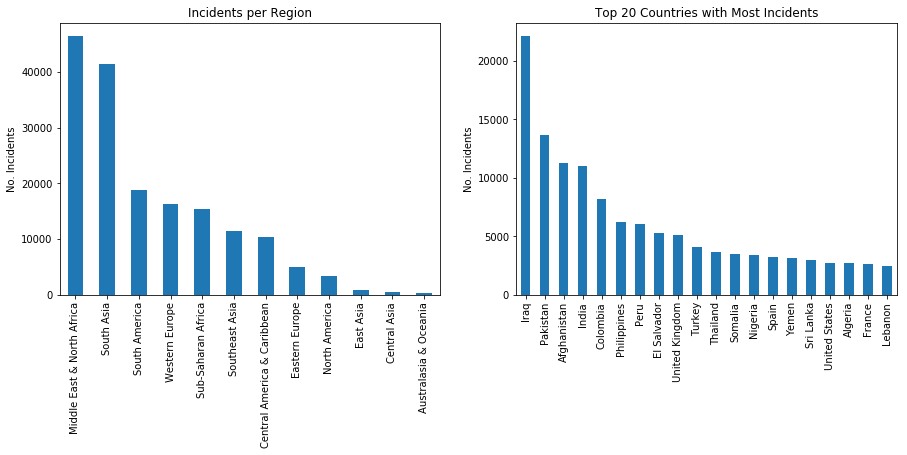

In [5]:
# No. of incidents per region
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df['region_txt'].value_counts().plot.bar(title='Incidents per Region')
plt.ylabel('No. Incidents')

plt.subplot(1,2,2)
df['country_txt'].value_counts()[:20].plot.bar(title='Top 20 Countries with Most Incidents')
plt.ylabel('No. Incidents');

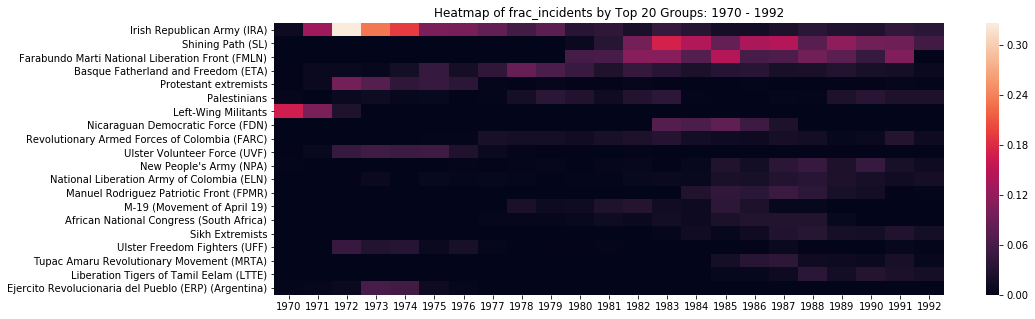

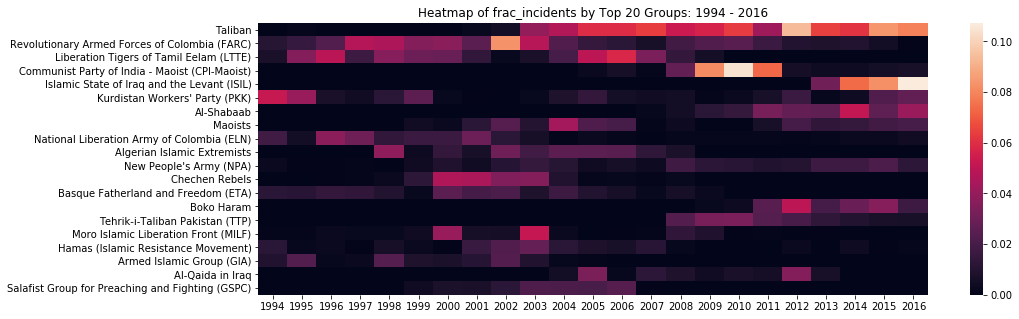

In [6]:
# MOST ACTIVE GROUPS PER YEAR

# incidents per year per group
grp_inc_yr = df.groupby([pd.Grouper(freq='A',key='date'),'gname'])['country_txt'].count()
grp_inc_yr = grp_inc_yr.unstack('gname',fill_value=0)
grp_inc_yr.name = 'n_incidents'
grp_inc_yr.index = grp_inc_yr.index.year
grp_inc_yr.index.name = 'year'

# fraction incidents per year
grp_frinc_yr = grp_inc_yr.div(tot_inc_yr,axis='rows')
grp_frinc_yr.name = 'frac_incidents'

# heatmap plot function
def plot_heatmap(data,year_range,n_groups=20):
    plot_groups = data.loc[year_range].sum().sort_values(ascending=False)[:n_groups].index
    plt.figure(figsize=(15,5))
    sns.heatmap(data[plot_groups].loc[year_range].T)
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Heatmap of {} by Top {} Groups: {} - {}'.format(data.name,n_groups,min(year_range),max(year_range)))

plot_heatmap(grp_frinc_yr,list(np.arange(1970,1993)))
plot_heatmap(grp_frinc_yr,list(np.arange(1994,2017)))

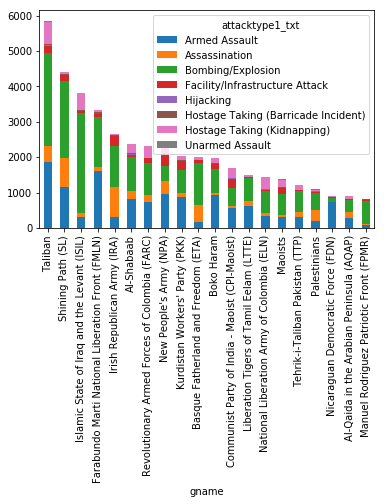

In [7]:
grp_att=df.groupby('gname')['attacktype1_txt'].value_counts().unstack('attacktype1_txt',fill_value=0)
grp_att['tot_inc'] = grp_att.sum(axis=1)
grp_att.sort_values(by='tot_inc',ascending=False).drop('tot_inc',axis=1).head(20).plot(kind='bar',stacked=True)